In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [10]:
# Load our data
df = pd.read_csv('/content/Date and model wise sale.csv')

In [11]:
# Take a look at our data contains
df.head()

,Date,Model,Count
0,31-Aug-16,M45,5
1,31-Aug-16,M121,3
2,31-Aug-16,M122,4
3,31-Aug-16,M91,10
4,31-Aug-16,M66,57


In [12]:
df.shape

(46116, 3)

We can see that there are a little over 46k samples and 3 features, one being the date. For the sake of this project, we only care about the date and count columns.

In [16]:
df = df[['Date', 'Count']]

In [17]:
df.tail()

,Date,Count
46111,01-Jan-14,1
46112,01-Jan-14,1
46113,01-Jan-14,5
46114,01-Jan-14,1
46115,01-Jan-14,1


In [19]:
# We want another column that represents the years the samples were recorded so that we can more easily seperate based on year.
df['year'] = pd.to_datetime(df['Date']).dt.year

If we have a large number of samples, we may need to perform a stratified random sample in order to get a more managable dataset for ARIMA model. The dataset is not too large, therefore I will not use random sampling.

In [ ]:
sampled_dataset = []
for year in df['year'].unique():
  sampled_dataset.append(df[df['year'] == year].sample(10000))

df = pd.concat(sampled_dataset)

In [22]:
# We want to view our data by timestamps, as this is a forecasting problem, so we change the date column to follow the data_time format and we set our index as the dates
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [23]:
df.drop(columns=['year'], inplace=True)

<Axes: xlabel='Date'>

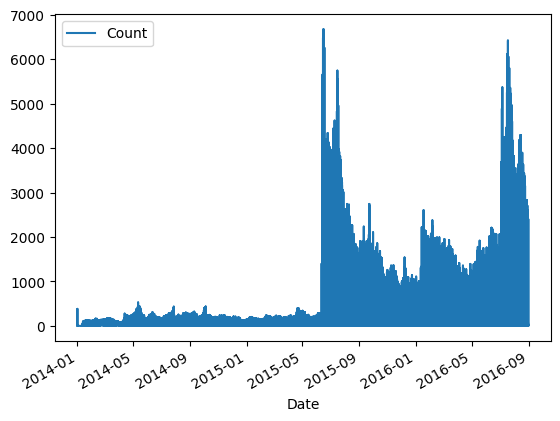

In [33]:
# Get an idea of what our sales plot looks like over time
df.plot()

The data looks relatively stationary, but we should use statistical tests to prove. We can use the adfuller test to determine if there is evidence of seasonality.


Ho: Data is non-stationary
Ha: Data is stationary
Significance Level = 0.05

In [38]:
result = sm.tsa.adfuller(df)
print(f'p-value: {result[1]}')

p-value: 0.0


Since p-value < 0.05, we can reject the null hypothesis. So, our data is indeed stationary, just like we thought.

This means that our d value would be 0, as 0 differncings were required to get our data to be stationary.

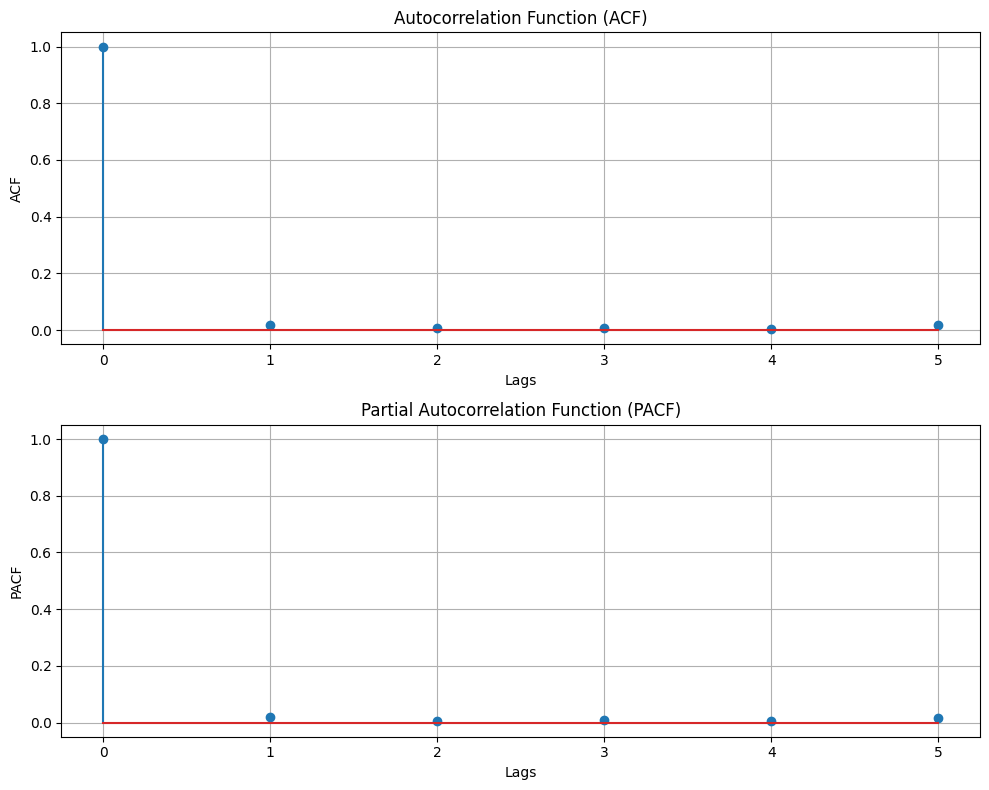

In [37]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Compute ACF and PACF using statsmodels
lags = 5  # Number of lags to consider for ACF and PACF

# Compute ACF and PACF
acf_values, confint, qstat = sm.tsa.acf(df, nlags=lags, qstat=True)
pacf_values = sm.tsa.pacf(df, nlags=lags)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF
ax[0].stem(range(lags + 1), acf_values)
ax[0].set_xlabel('Lags')
ax[0].set_ylabel('ACF')
ax[0].set_title('Autocorrelation Function (ACF)')
ax[0].grid(True)

# Plot PACF
ax[1].stem(range(lags + 1), pacf_values)
ax[1].set_xlabel('Lags')
ax[1].set_ylabel('PACF')
ax[1].set_title('Partial Autocorrelation Function (PACF)')
ax[1].grid(True)

plt.tight_layout()
plt.show()

Since both PACF and ACF graphs drop to near 0 after the 0th lag, this means that our data might just be white noise. However, I will still use ARIMA for demonstration purposes. We can use a low p and q value as there is little to no correlation between the counts over time. p will be equal to 1 and q will be equal to 1.

Before we use the (p, d, q) that we found, we could use pmdarima to confirm that our values are correct.

In [ ]:
! pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.2 MB/s eta 0:00:00


In [ ]:
import pmdarima as pm
import time

I won't actually run the below code because even with only 46k samples, the model still takes a very long time to give us the results. We can just the values we found instead, but here is how we could confirm our values if we wanted to.

In [ ]:
start = time.time()
model = pm.auto_arima(train)
print(f'Time taken: {time.time() - start} s')
model.summary()

In [41]:
# Now lets train our ARIMA
main_model = sm.tsa.ARIMA(df, order=(1, 0, 1))
results = main_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Count   No. Observations:                46116
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -330721.344
Date:                Fri, 04 Aug 2023   AIC                         661450.689
Time:                        15:05:40   BIC                         661485.644
Sample:                             0   HQIC                        661461.680
                              - 46116                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         96.6901      2.770     34.907      0.000      91.261     102.119
ar.L1          0.3961      0.189      2.100      0.036       0.026       0.766
ma.L1         -0.3778      0.190     -1.984      0.047      -0.751      -0.005
sigma2      9.924e+04    166.371    596.474      0.000    9.89e+04    9.96e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):          20414789.02
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             8.52
Prob(H) (two-sided):                  0.00   Kurtosis:                       104.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
# Forecast the next 6 months
forecast_steps = 6
forecast = results.forecast(steps=forecast_steps)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


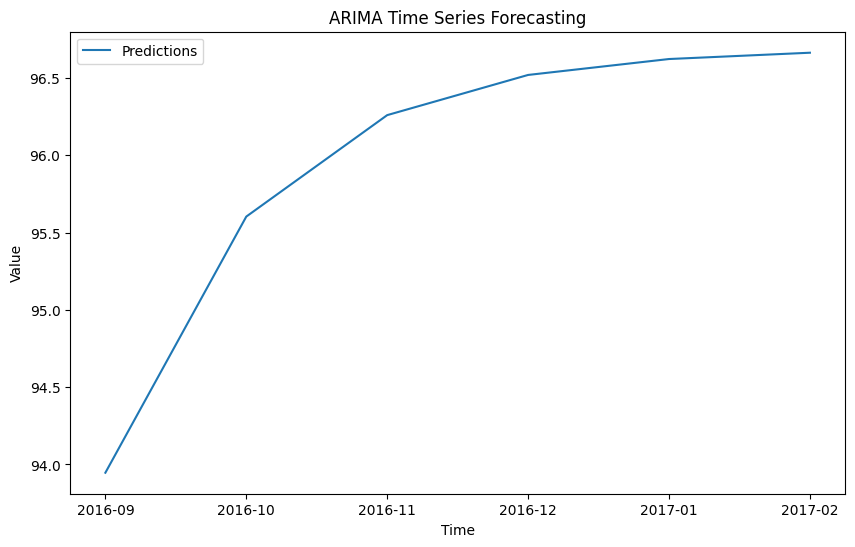

In [55]:
time_line = ['2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02']

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(time_line, forecast, label='Predictions')
plt.title('ARIMA Time Series Forecasting')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


Although we have no test set to confirm these predictions, we can still see that the the predictions are not that accurate. In the original data, the counts went to the thousands range but here its dropping after not even 100. This definetely was not the best situation to use the ARIMA model but hopefully this gives some understanding of how ARIMA could be implemented.